In [1]:
import pickle
import torch
from torch import nn
class AutoEncoder(nn.Module):
    def __init__(self, activation_size, n_dict_components, t_type=torch.float16):
        super(AutoEncoder, self).__init__()
        # create decoder using float16 to save memory
        self.decoder = nn.Linear(n_dict_components, activation_size, bias=True)
        # Initialize the decoder weights orthogonally
        nn.init.orthogonal_(self.decoder.weight)
        self.decoder = self.decoder.to(t_type)

        self.encoder = nn.Sequential(
            nn.Linear(activation_size, n_dict_components).to(t_type),
            nn.ReLU()
        )
        
    def forward(self, x):
        c = self.encoder(x)
        # Apply unit norm constraint to the decoder weights
        self.decoder.weight.data = nn.functional.normalize(self.decoder.weight.data, dim=0)
    
        x_hat = self.decoder(c)
        return x_hat, c
    
    @property
    def device(self):
        return next(self.parameters()).device
    
# Initialize an empty list to store the loaded data
autoencoders = []
av_activations = []

# Loop over the file indices
for i in range(20):  # 20 because you said up to 19, range stops one step before the stop argument
    # Create the file path
    # file_path_auto = f"outputs/20230624-035145/minirun{i}/autoencoders.pkl"
    # file_path_activation = f"outputs/20230624-035145/minirun{i}/av_activations.pkl"
    # file_path_auto = f"/root/sparse_coding/outputs/20230709-120910-EleutherAI/pythia-1.4b-deduped-15/minirun{i}/autoencoders.pkl"
    # file_path_activation = f"/root/sparse_coding/outputs/20230709-120910-EleutherAI/pythia-1.4b-deduped-15/minirun{i}/av_activations.pkl"
    file_path_auto = f"/root/sparse_coding/outputs/20230709-120910-EleutherAI/pythia-1.4b-deduped-15/minirun{i}/autoencoders.pkl"
    file_path_activation = f"/root/sparse_coding/outputs/20230709-120910-EleutherAI/pythia-1.4b-deduped-15/minirun{i}/av_activations.pkl"

    # Open the file and load the data
    with open(file_path_auto, 'rb') as file:
        autoencoders.append(pickle.load(file))

    with open(file_path_activation, 'rb') as file:
        av_activations.append(pickle.load(file))

In [2]:
dictionary_2k = [ae[0][0].decoder.weight.data.T for ae in autoencoders]
dictionary_4k = [ae[0][1].decoder.weight.data.T for ae in autoencoders]
dictionary_8k = [ae[0][2].decoder.weight.data.T for ae in autoencoders]

av_2k = [act[0][0] for act in av_activations]
av_4k = [act[0][1] for act in av_activations]
av_8k = [act[0][2] for act in av_activations]

In [12]:
print(dictionary_4k[0].shape)

torch.Size([4096, 2048])


In [6]:
from scipy.optimize import linear_sum_assignment
import numpy as np
def run_mmcs_with_larger(smaller_dict, larger_dict, device):
    smaller_dict_features, _ = smaller_dict.shape
    larger_dict_features, _ = larger_dict.shape
    # Hungary algorithm
    # Calculate all cosine similarities and store in a 2D array
    cos_sims = np.zeros((smaller_dict_features, larger_dict_features))
    larger_dict = larger_dict.to(device)
    for idx, vector in enumerate(smaller_dict):
        cos_sims[idx] = torch.nn.functional.cosine_similarity(vector.to(device), larger_dict, dim=1).cpu().numpy()
    # Convert to a minimization problem
    cos_sims = 1 - cos_sims
    # Use the Hungarian algorithm to solve the assignment problem
    row_ind, col_ind = linear_sum_assignment(cos_sims)
    # Retrieve the max cosine similarities and corresponding indices
    max_cosine_similarities = 1 - cos_sims[row_ind, col_ind]
    
    return max_cosine_similarities, row_ind, col_ind

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
time_series_N = len(dictionary_2k)
neurons = dictionary_2k[i].shape[0]
self_sim = np.zeros((time_series_N-1, neurons))
self_sim_larger = np.zeros((time_series_N-1, neurons))
mcs = np.zeros((time_series_N, neurons))
matched_larger_features_index = np.zeros((time_series_N, neurons), dtype=int)
for i in range(time_series_N):
    print("i:", i)
    mcs[i], _, col = run_mmcs_with_larger(dictionary_2k[i], dictionary_4k[i], device)
    # Index larger self_sim by col
    matched_larger_features_index[i] = col
    if(i != time_series_N-1):
        self_sim_larger[i] =  torch.nn.functional.cosine_similarity(dictionary_4k[i].to(device), dictionary_4k[i+1].to(device), dim=1).cpu().numpy()[col]
        self_sim[i] = torch.nn.functional.cosine_similarity(dictionary_2k[i].to(device), dictionary_2k[i+1].to(device), dim=1).cpu().numpy()

i: 0
i: 1
i: 2
i: 3
i: 4
i: 5
i: 6
i: 7
i: 8
i: 9
i: 10
i: 11
i: 12
i: 13
i: 14
i: 15
i: 16
i: 17
i: 18
i: 19


In [8]:
av_2k_np = np.array(av_2k)
av_4k_np = np.array(av_4k)
av_8k_np = np.array(av_8k)

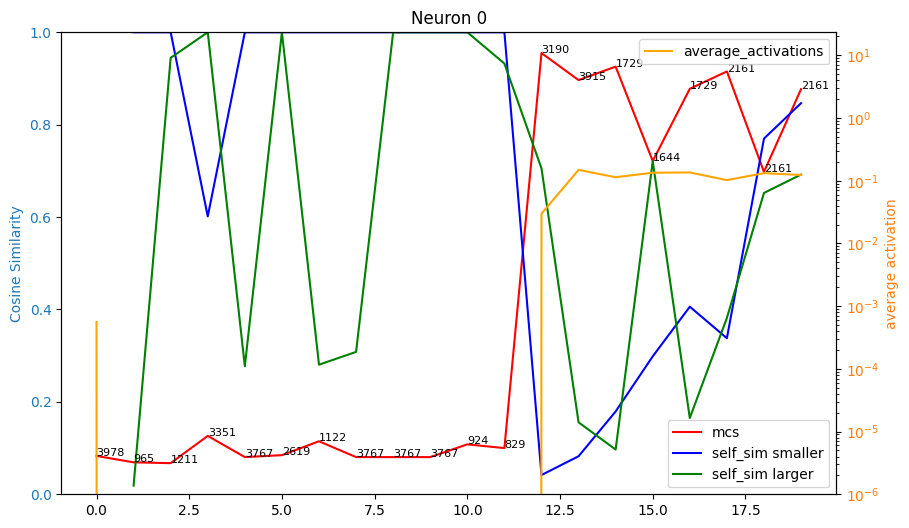

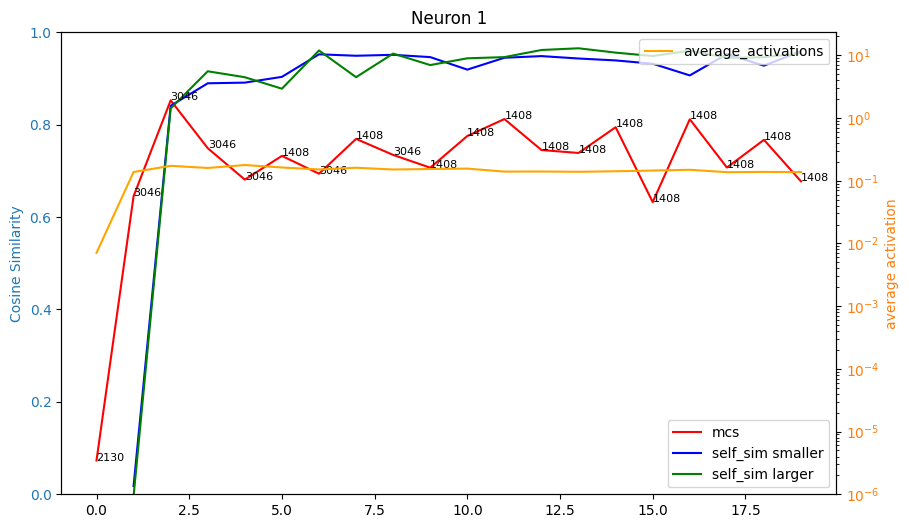

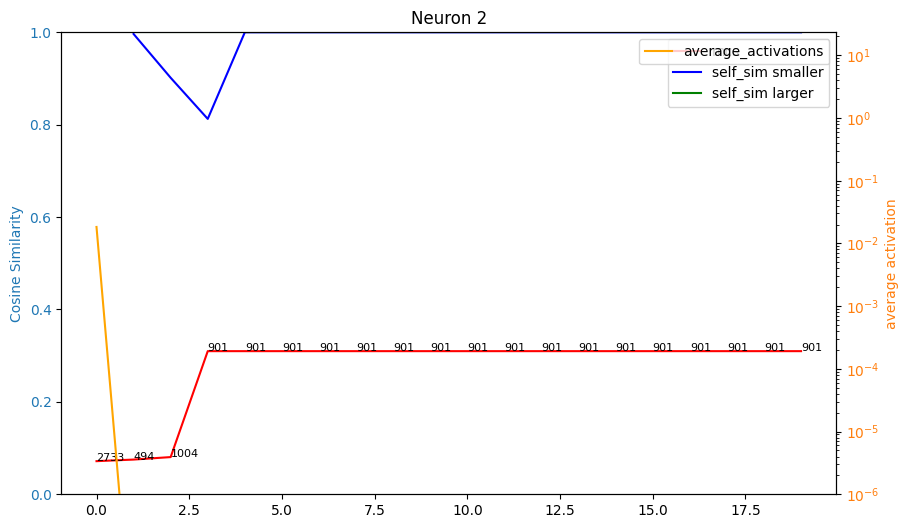

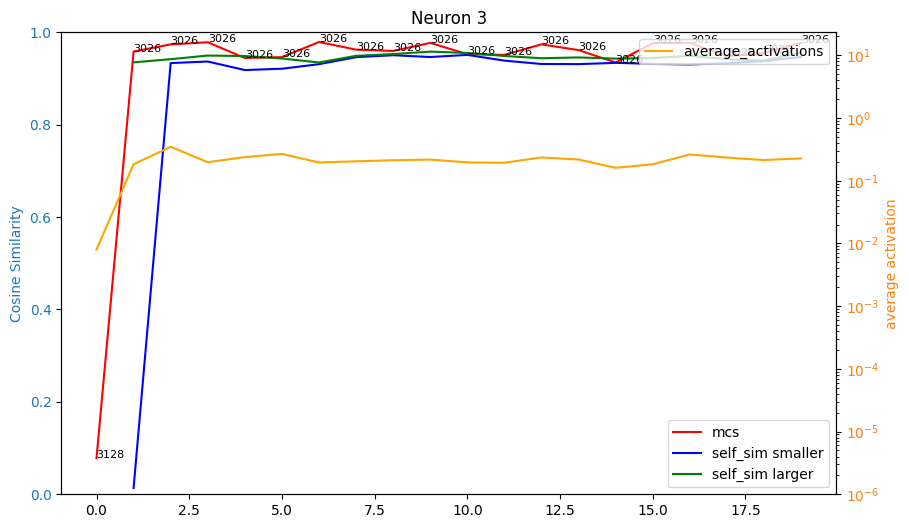

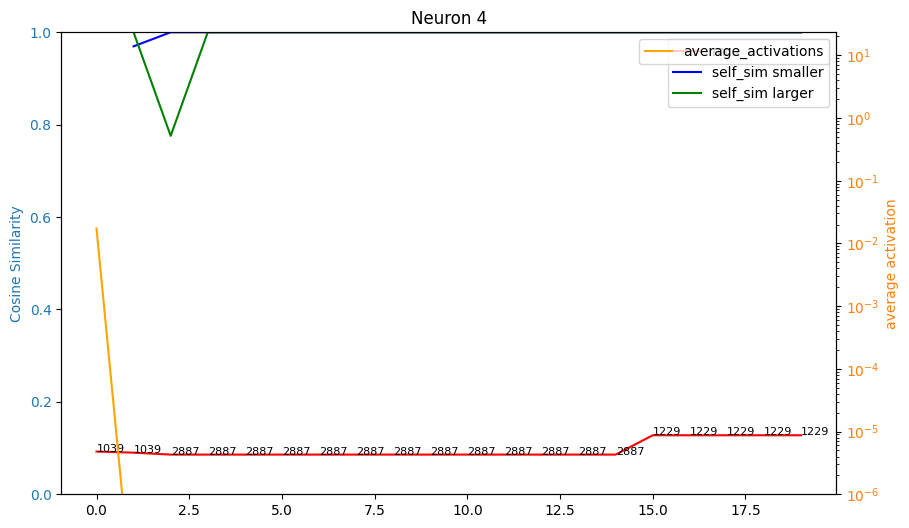

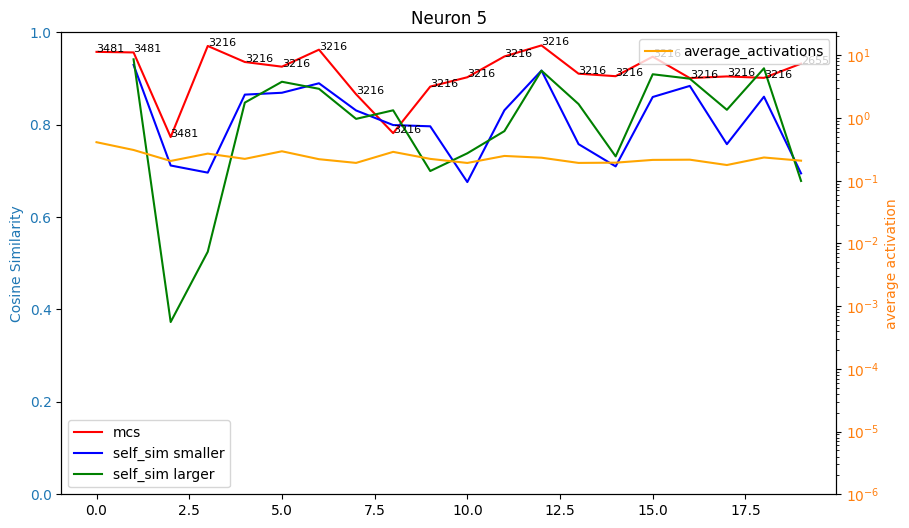

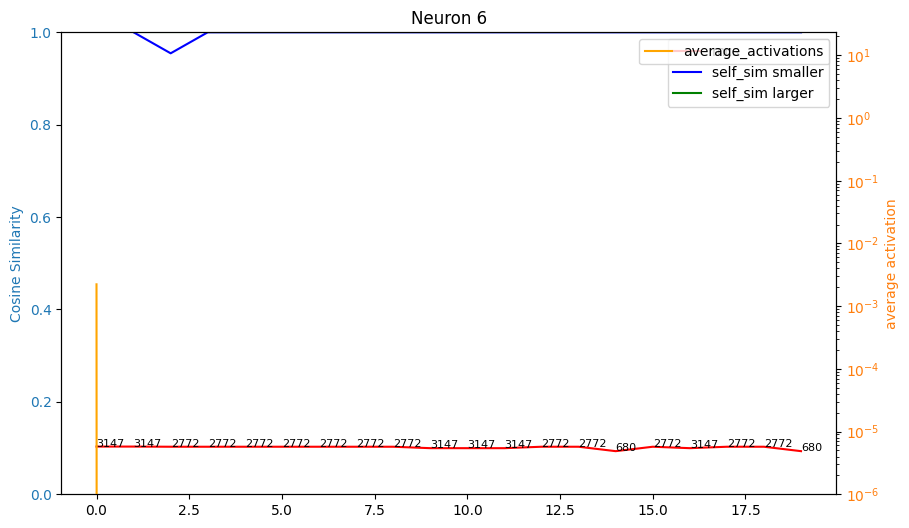

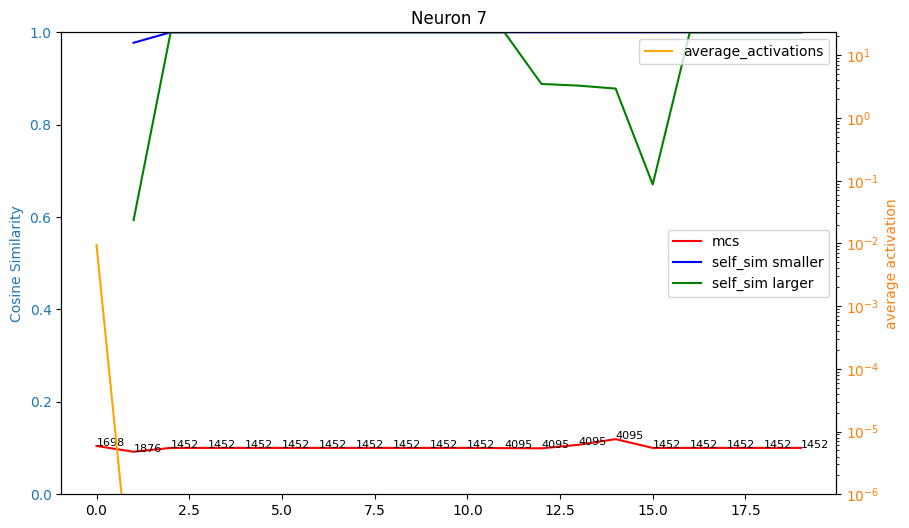

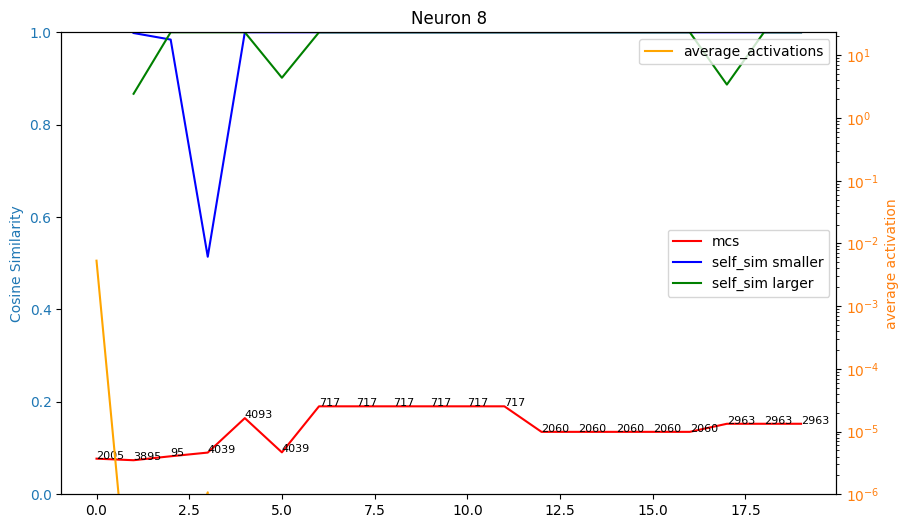

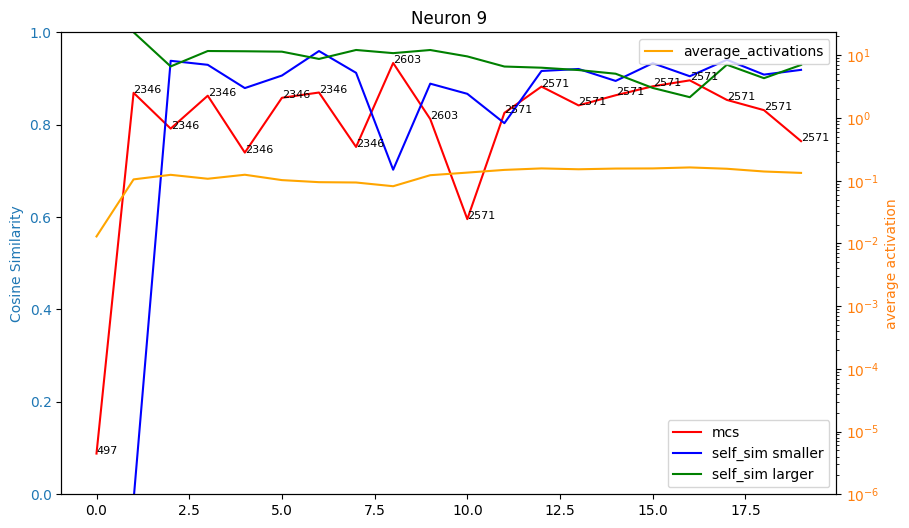

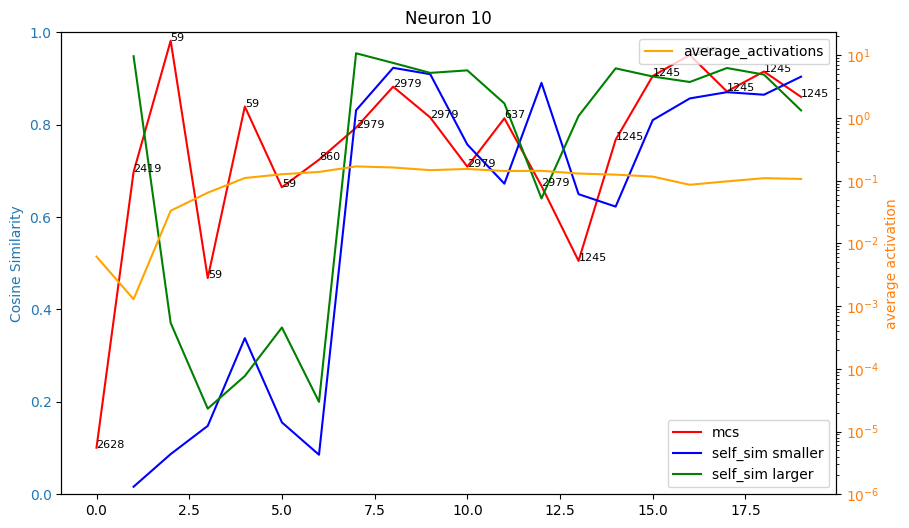

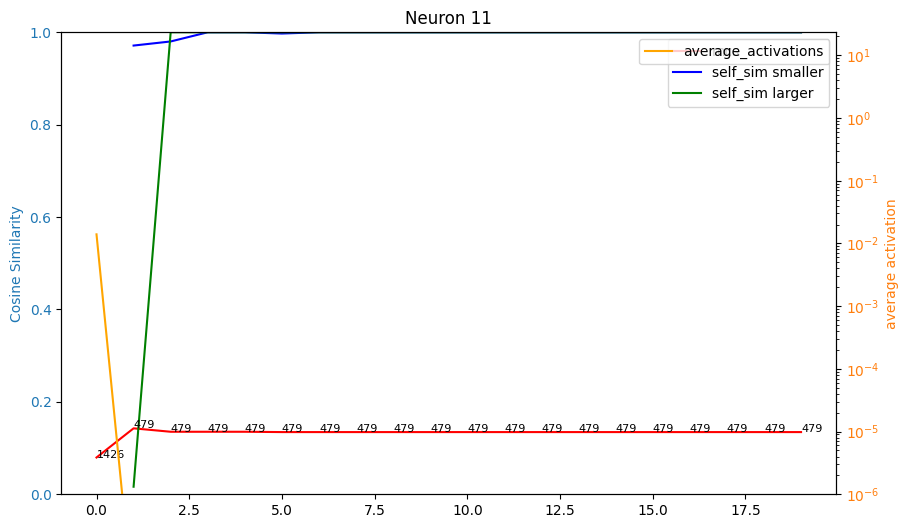

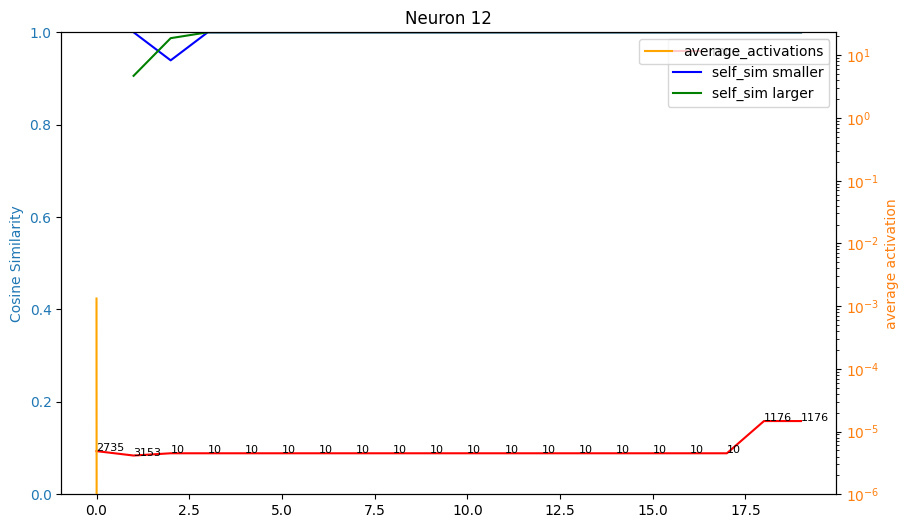

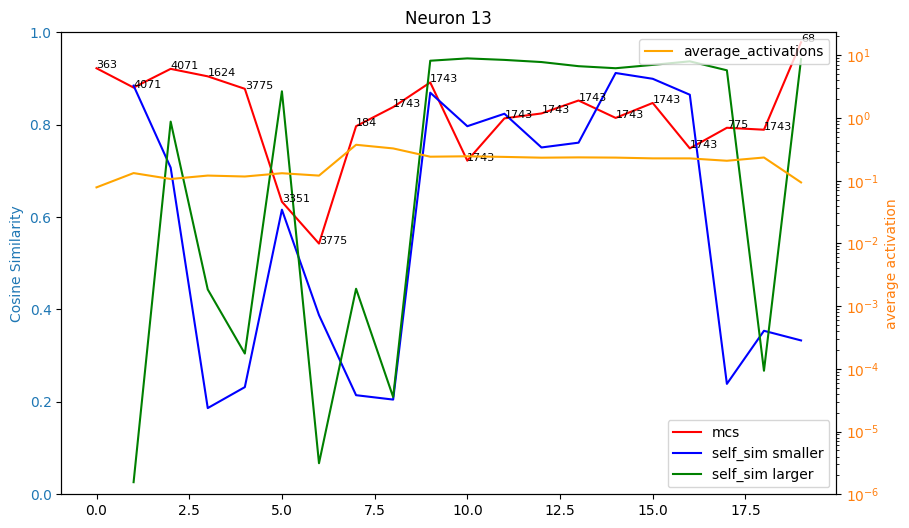

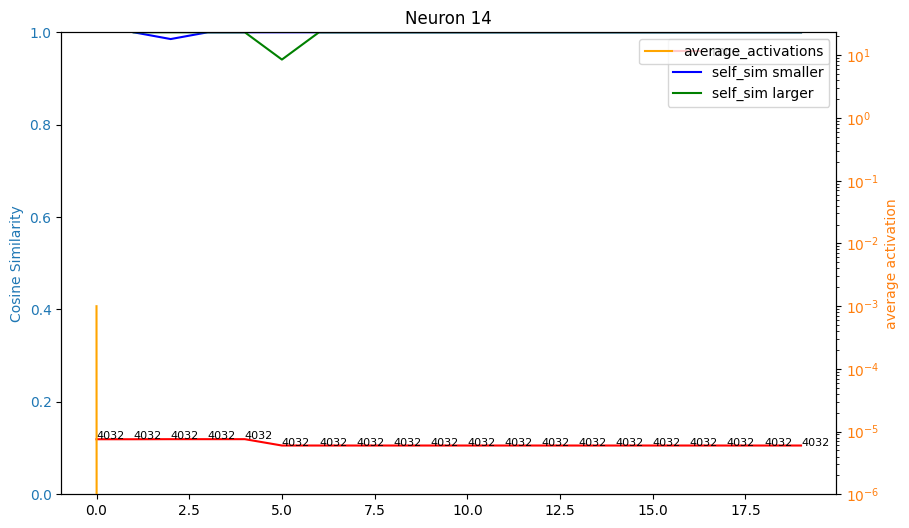

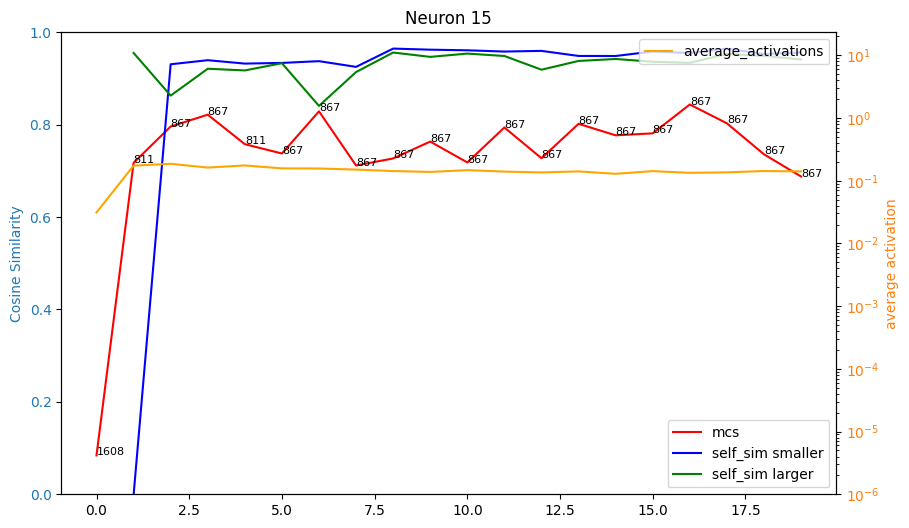

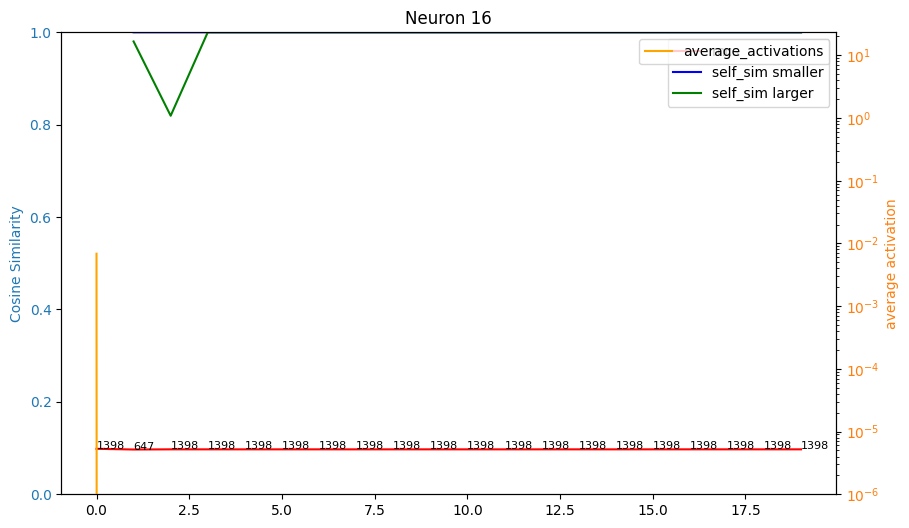

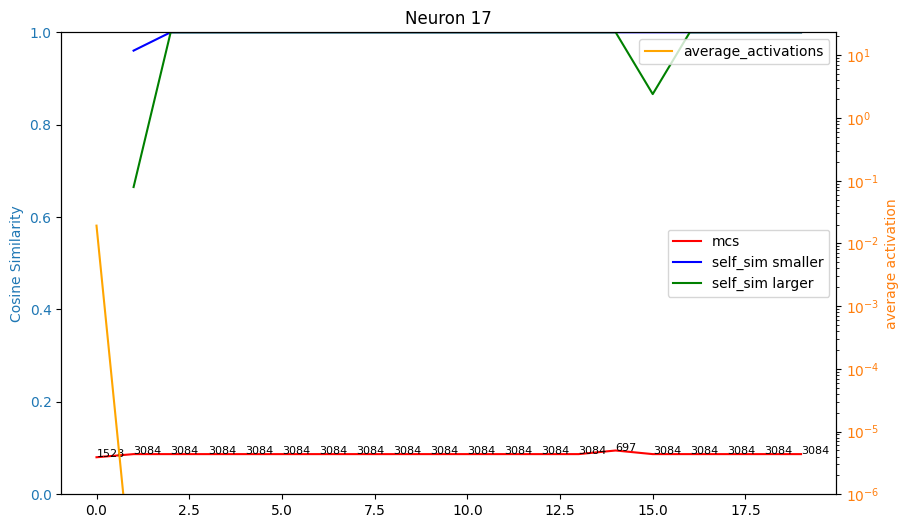

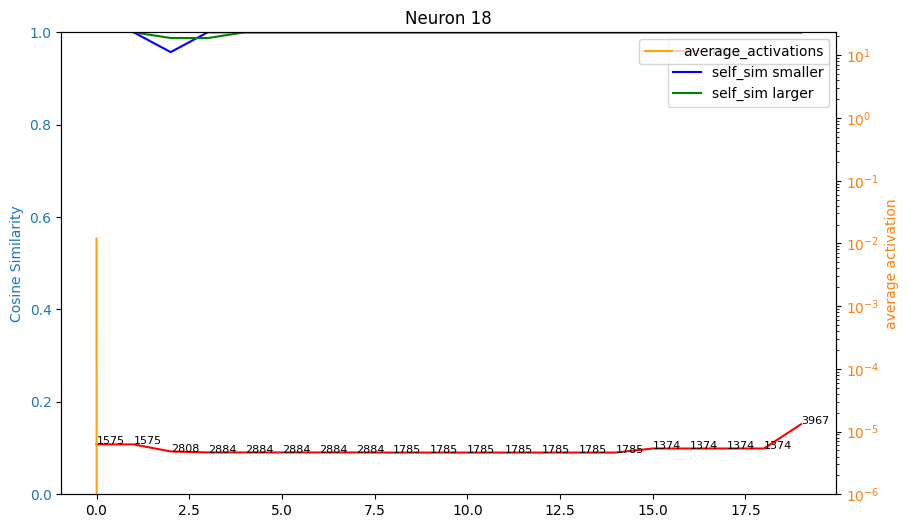

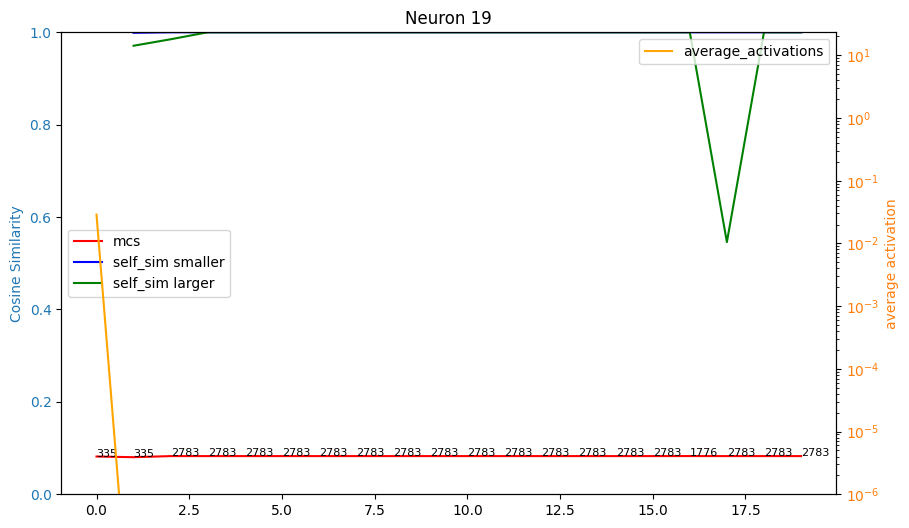

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
time_steps = np.arange(time_series_N)
time_steps_self_sim = np.arange(1, time_series_N)
N = 0
max_activation = av_2k_np.max()
for N in range(N, N + 20):
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.title(f"Neuron {N}")
    # set ylim to 0, 1
    ax.set_ylim(0, 1)
    plt.plot(time_steps, mcs[:,N], label="mcs", color="red")
    for i, txt in enumerate(matched_larger_features_index[:, N]):
        plt.text(time_steps[i], mcs[i, N], str(txt), fontsize=8)
    plt.plot(time_steps_self_sim, self_sim[:,N], label="self_sim smaller", color="blue")
    plt.plot(time_steps_self_sim, self_sim_larger[:,N], label="self_sim larger", color="green")
    # Annotate each point on the line

    color = 'tab:blue'
    ax.set_ylabel('Cosine Similarity', color=color)
    ax.tick_params(axis='y', labelcolor=color)
    ax.legend()
    ax2 = ax.twinx()  
    ax2.plot(av_2k_np[:,N], label="average_activations", color="orange")
    ax2.set_yscale('log')
    ax2.set_ylim(1e-6, max_activation)
    color = 'tab:orange'
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylabel('average activation', color=color)
    ax2.legend()    

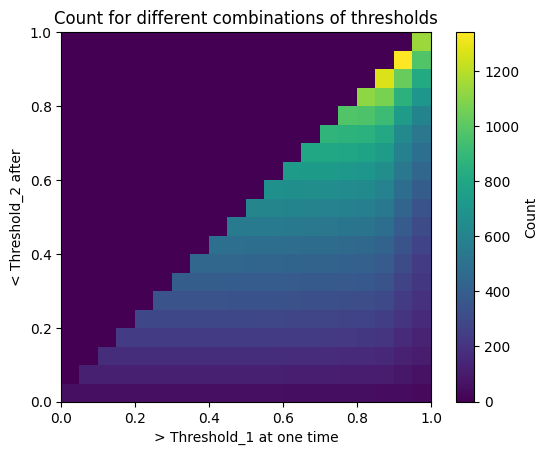

In [10]:

# import numpy as np
# import matplotlib.pyplot as plt
matrix = self_sim_larger

# Assuming 'matrix' is your 19 x 2048 matrix
# matrix = np.random.rand(19, 2048)  # Just a placeholder

# Define your linspace values
threshold_1_values = np.linspace(0, 1, 20)
threshold_2_values = np.linspace(0, 1, 20)

# Initialize a 2D array to store the counts for each combination
counts = np.zeros((len(threshold_1_values), len(threshold_2_values)))

for i, threshold_1 in enumerate(threshold_1_values):
    for j, threshold_2 in enumerate(threshold_2_values):
        if threshold_2 > threshold_1:
            continue  # Skip if threshold_2 is greater than threshold_1

        # Calculate count for this combination of thresholds
        count = 0
        for k in range(matrix.shape[1]):  # Loop over each vector (columns)
            vector = matrix[:, k]
            indices = np.where(vector >= threshold_1)[0]
            if len(indices) == 0:
                continue

            for index in indices:
                if np.any(vector[index + 1:] < threshold_2):
                    count += 1
                    break

        # Store the count
        counts[i, j] = count

# Create the plot
plt.imshow(counts.T, origin='lower', extent=[0, 1, 0, 1])
plt.colorbar(label='Count')
plt.ylabel('< Threshold_2 after')
plt.xlabel('> Threshold_1 at one time')
plt.title('Count for different combinations of thresholds')
plt.show()

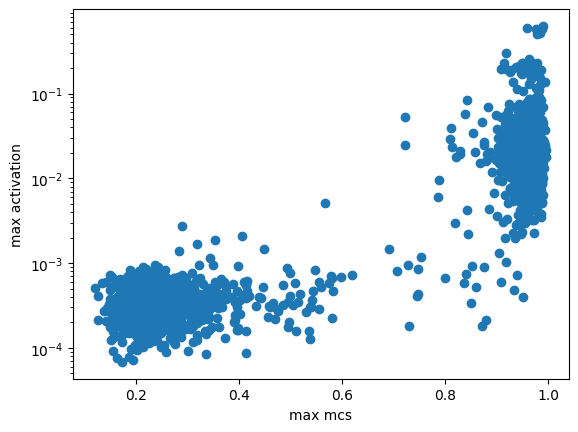

In [37]:
# It seems like high MCS is correlated w/ high activation. We can check this by plotting the MCS vs. activation
# First reduce each neuron dim to it's max value (max mcs & max activation))
max_mcs = mcs.max(axis=0) 
max_activation = av_2k_np.max(axis=0)

# Plot the max mcs vs. max activation
plt.scatter(max_mcs, max_activation)
plt.xlabel("max mcs")
plt.ylabel("max activation")
# put y axis on log scale
plt.yscale('log')
plt.show()

In [50]:
# Hypothesis: many high MCS features have many matching features in the larger dictionary
# to start, can just plot the full cos_sim matrix for a high MCS feautre & a low MCS feature
# Let's restrict ourselves to the last time step
high_mcs_feature_index = np.argmax(mcs[-1])
low_mcs_feature_index = np.argmin(mcs[-1])

In [72]:
high_mcs_feature_index

16

In [79]:
high_mcs_cs = torch.nn.functional.cosine_similarity(dictionary_2k[16][45].to(device), dictionary_4k[-1].to(device), dim=1).cpu().numpy()
low_mcs_cs = torch.nn.functional.cosine_similarity(dictionary_2k[-1][low_mcs_feature_index].to(device), dictionary_4k[-1].to(device), dim=1).cpu().numpy()

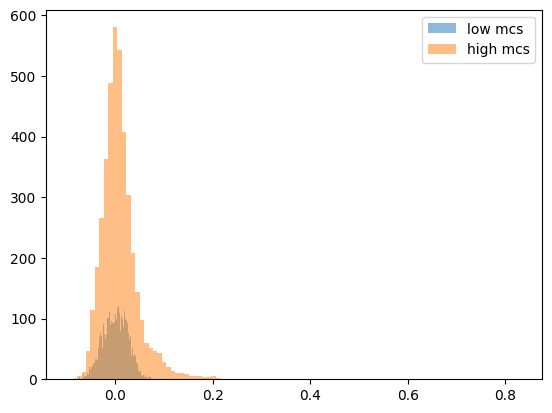

In [80]:
# Plot a histogram of the cosine similarities
plt.hist(low_mcs_cs, bins=100, alpha=0.5, label="low mcs")
plt.hist(high_mcs_cs, bins=100, alpha=0.5, label="high mcs")
plt.legend(loc='upper right')
plt.show()

In [98]:
feature = 2
for x in range(20):
    high_mcs_cs = torch.nn.functional.cosine_similarity(dictionary_2k[x][feature].to(device), dictionary_4k[x].to(device), dim=1).cpu().numpy()
    thresh = 0.5
    print(f"Number of high mcs features w/ cs > {thresh}:", (high_mcs_cs > thresh).sum())
    print(high_mcs_cs.argmax(), ":", high_mcs_cs.max())

Number of high mcs features w/ cs > 0.5: 1
1788 : 0.86914814
Number of high mcs features w/ cs > 0.5: 1
1788 : 0.9073901
Number of high mcs features w/ cs > 0.5: 1
1788 : 0.8803295
Number of high mcs features w/ cs > 0.5: 1
1788 : 0.90463734
Number of high mcs features w/ cs > 0.5: 1
1788 : 0.9280826
Number of high mcs features w/ cs > 0.5: 1
1788 : 0.93301946
Number of high mcs features w/ cs > 0.5: 1
1788 : 0.8978471
Number of high mcs features w/ cs > 0.5: 2
3151 : 0.8216855
Number of high mcs features w/ cs > 0.5: 1
3151 : 0.95717835
Number of high mcs features w/ cs > 0.5: 1
3151 : 0.95661044
Number of high mcs features w/ cs > 0.5: 1
3151 : 0.8755295
Number of high mcs features w/ cs > 0.5: 1
3151 : 0.87297475
Number of high mcs features w/ cs > 0.5: 1
3151 : 0.91425675
Number of high mcs features w/ cs > 0.5: 1
3151 : 0.92777705
Number of high mcs features w/ cs > 0.5: 2
3151 : 0.8878552
Number of high mcs features w/ cs > 0.5: 1
3151 : 0.9443461
Number of high mcs features w/ c

Hypothesis seems false. There are at most 2 or 3 that have high MCS w/ the feature, but it's inconsistant. 

# Checking Encoder Bias

In [9]:
# What if the encoder has a huge negative bias towards specific features? Let's just plot them for the diff dictionaries
encoder_2k = [ae[0][0].encoder[0] for ae in autoencoders]
encoder_4k = [ae[0][1].encoder[0] for ae in autoencoders]
encoder_8k = [ae[0][2].encoder[0] for ae in autoencoders]

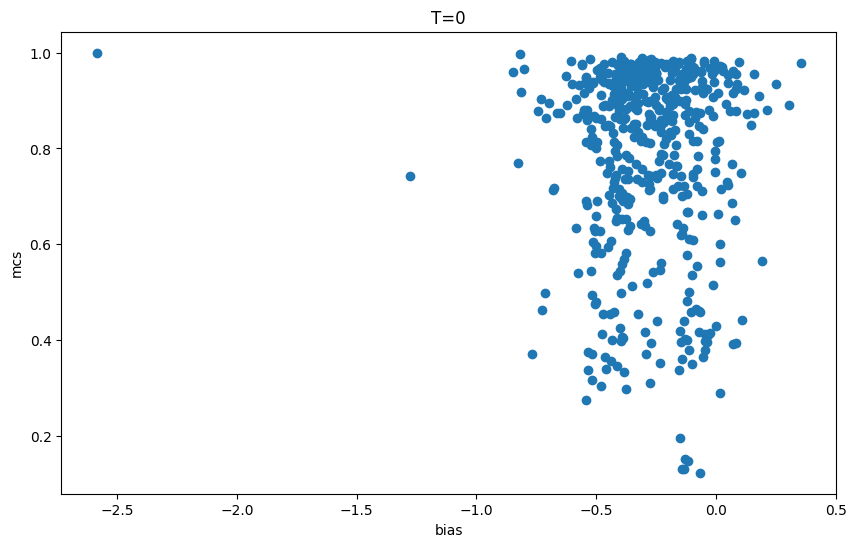

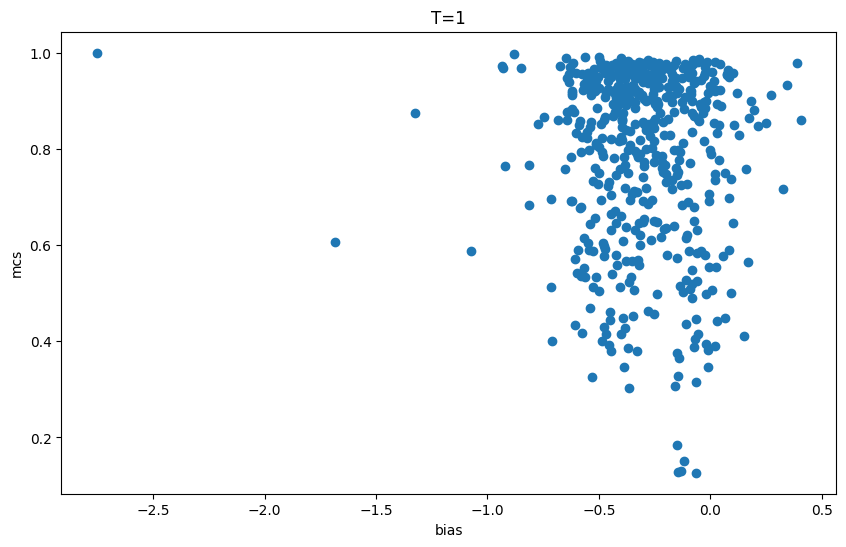

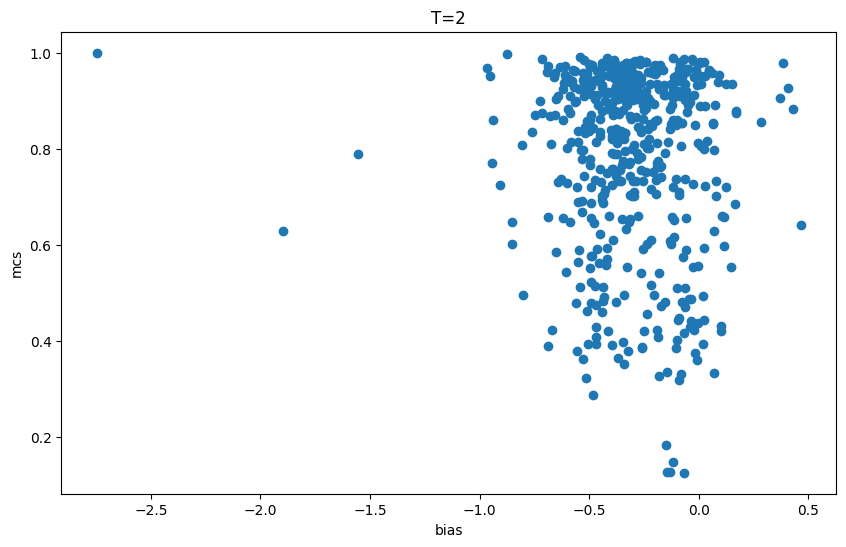

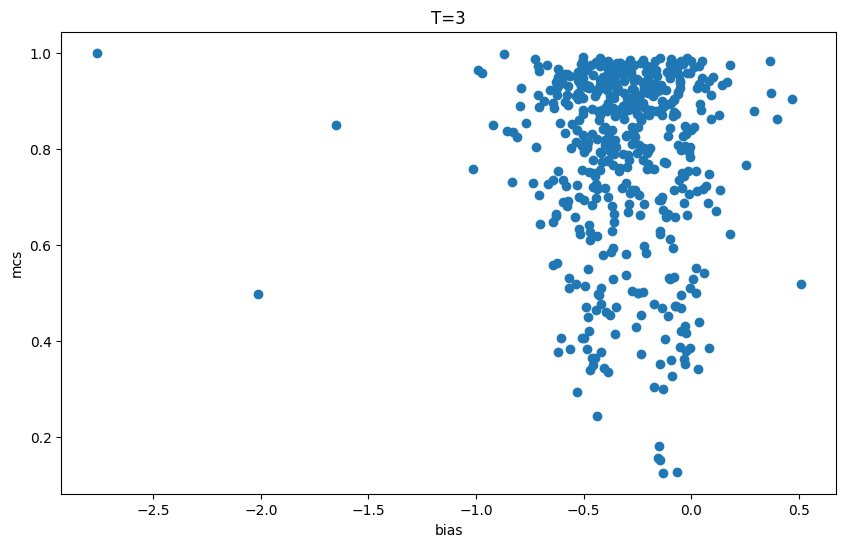

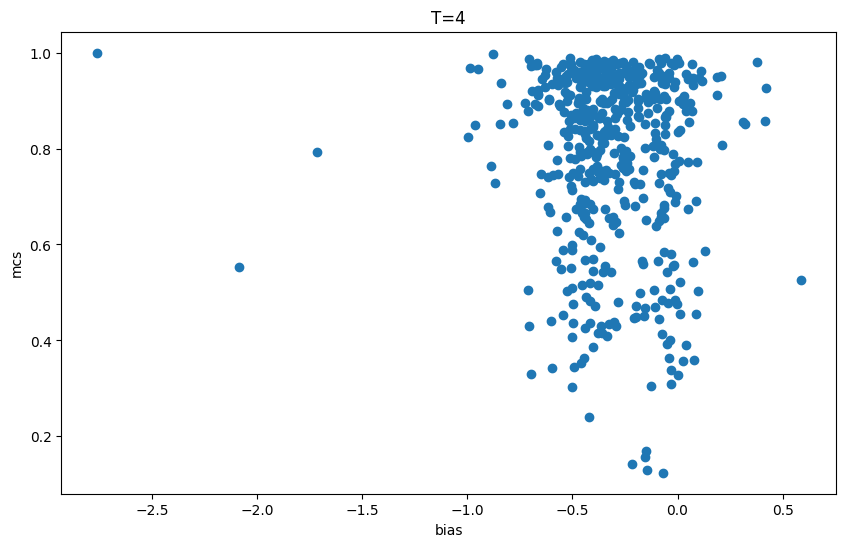

In [10]:
for n in range(5):
    fig, ax = plt.subplots(figsize=(10, 6))
#     print(f"T={n} | mean: {bias_2k.mean():.3f}, min: {bias_2k.min():.3f}, max: {bias_2k.max():.3f}, std: {bias_2k.std():.3f}")
# bias_4k = encoder_4k[n].bias.detach().cpu().numpy()
# bias_8k = encoder_8k[n].bias.detach().cpu().numpy()
# Plot the bias agains the mcs
    bias_2k = encoder_2k[n].bias.detach().cpu().numpy()
    ax.scatter(bias_2k, mcs[n])
    plt.xlabel("bias")
    plt.ylabel("mcs")
    plt.title(f"T={n}")
plt.show()

In [44]:
time_steps.shape, self_sim_np.shape, mcs_np.shape

((19,), (19, 2048), (19, 2048))

In [40]:
dictionary_2k[i].shape[0]

2048

In [25]:
d1 = torch.rand(10,2)
d2 = torch.rand(10,2)
torch.nn.functional.cosine_similarity(d1, d1, dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])